In [38]:
# IMPORTING LIBRARIES

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import statsmodels.api as sm


### CLEANING DATASET


In [3]:
df = pd.read_csv('simulated_champagne_sales.csv')

In [4]:
df.head()

,Month,Sales (dozens)
0,2000-01-31,134.93
1,2000-02-29,142.06
2,2000-03-31,166.01
3,2000-04-30,178.34
4,2000-05-31,126.42


In [7]:
# remove the date from the dataset [2000-01-31] -> [2000-01]

df['Month'] = pd.to_datetime(df['Month'], errors='coerce')

df['Month'] = df['Month'].dt.strftime("%Y-%m")

# To save the updated csv
# df.to_csv("updated_dataset.csv", index=False) 

# Update column name
df.columns = ['Month', 'Sales']


In [8]:
df.head()

,Month,Sales
0,2000-01,134.93
1,2000-02,142.06
2,2000-03,166.01
3,2000-04,178.34
4,2000-05,126.42


In [10]:
# checking if there are null values in the dataset

df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [12]:
# convert the Month column in to datetime format
df['Month'] = pd.to_datetime(df['Month'])

In [14]:
df.set_index('Month', inplace=True)

In [16]:
df.head()

,Sales
Month,
2000-01-01,134.93
2000-02-01,142.06
2000-03-01,166.01
2000-04-01,178.34
2000-05-01,126.42


## DATA VISUALIZATION

<Axes: xlabel='Month'>

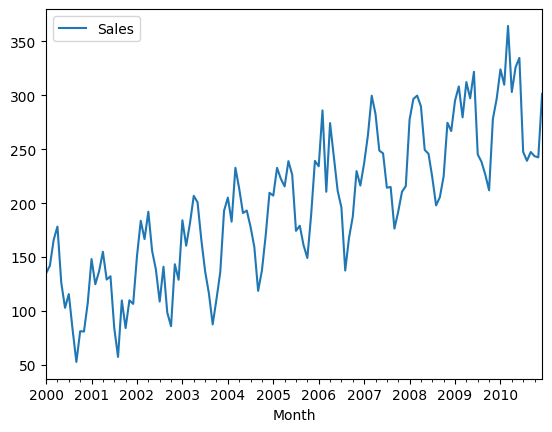

In [17]:
df.plot()

In [18]:
# test for stationarity

from statsmodels.tsa.stattools import adfuller 

test_result = adfuller(df['Sales']) 

In [23]:
# H0 = Non-Stationary
# H1 = Stationary

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', '#Observations Used'] #->no. of
    for value, label in zip(result, labels):
        print(label+' : ' + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and it is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

In [24]:
adfuller_test(df['Sales'])

ADF Test Statistic : 0.18491423451898717
p-value : 0.9714026727757321
#Lags Used : 13
#Observations Used : 118
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


### DIFFERENCING

`
Differencing is a technique used in time series analysis to make a dataset stationary, which is a key requirement for models like ARIMA. It transforms the dataset by subtracting consecutive observations to remove trends or seasonality.
`

In [25]:
df['Sales Difference'] = df['Sales'] - df['Sales'].shift(1)

In [28]:
df['Seasonal Difference'] = df['Sales'] - df['Sales'].shift(12)

In [30]:
df

,Sales,Sales Difference,Seasonal Difference
Month,,,
2000-01-01,134.93,NaN,NaN
2000-02-01,142.06,7.13,NaN
2000-03-01,166.01,23.95,NaN
2000-04-01,178.34,12.33,NaN
2000-05-01,126.42,-51.92,NaN
...,...,...,...
2010-08-01,239.27,-8.29,0.97
2010-09-01,247.41,8.14,21.00
2010-10-01,243.58,-3.83,31.63


In [31]:
adfuller_test(df['Seasonal Difference'].dropna())

ADF Test Statistic : -4.732479269874476
p-value : 7.309234687732134e-05
#Lags Used : 11
#Observations Used : 108
Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and it is stationary


<Axes: xlabel='Month'>

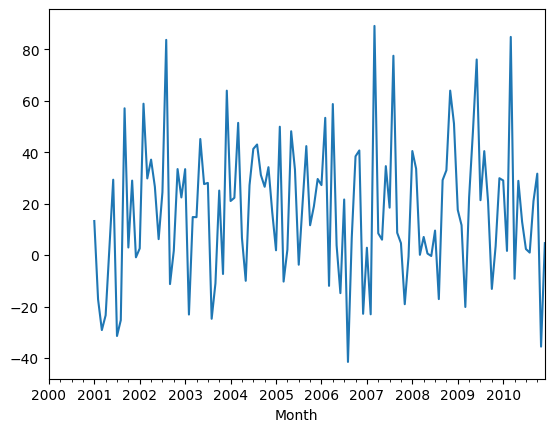

In [32]:
df['Seasonal Difference'].plot()

### AUTO REGRESSIVE MODEL

The general formula for an AR(p) model is:

$$
y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \epsilon_t
$$

Where:
- $y_t$ is the value of the time series at time $t$,
- $c$ is a constant (intercept),
- $\phi_i$ are the coefficients for each lag ($i = 1$ to $p$),
- $y_{t-i}$ are the lagged values,
- $\epsilon_t$ is the white noise (error term) at time $t$.


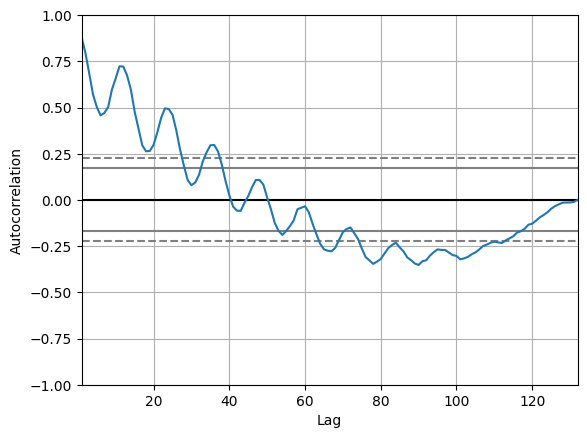

In [36]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

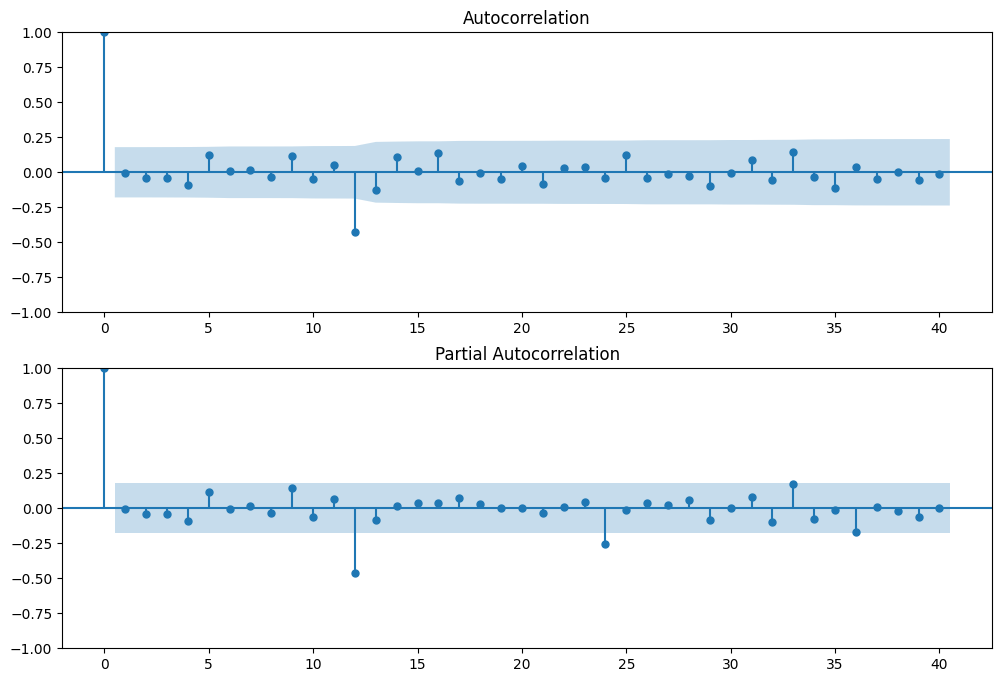

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)  # (rows, colls, index)

fig = sm.graphics.tsa.plot_acf(df['Seasonal Difference'].iloc[13:], lags=40,ax=ax1)
ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(df['Seasonal Difference'].iloc[13:], lags=40,ax=ax2)

### MODEL TESTING

In [43]:
from statsmodels.tsa.arima.model import ARIMA 

model = ARIMA(df['Sales'], order=(1,1,1))
results = model.fit()

/home/anson/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [44]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -638.704
Date:                Sun, 22 Dec 2024   AIC                           1283.408
Time:                        15:22:52   BIC                           1292.034
Sample:                    01-01-2000   HQIC                          1286.913
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3983      0.600     -0.664      0.507      -1.574       0.777
ma.L1          0.2748      0.640      0.429      0.668      -0.979       1.529
sigma2      1005.4368    146.503      6.863      0.0

<Axes: xlabel='Month'>

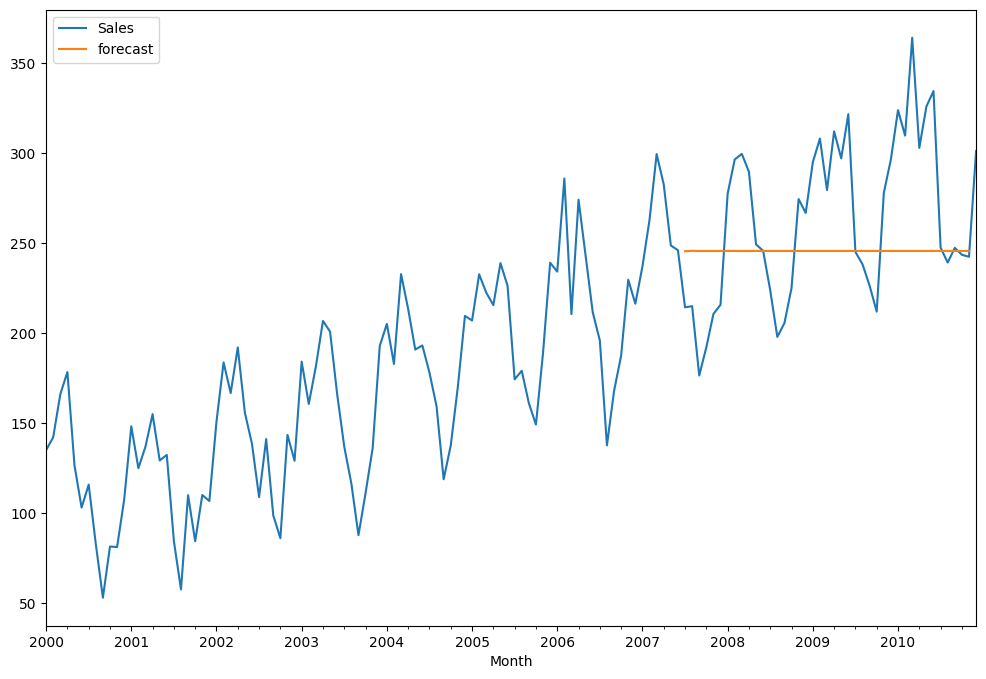

In [47]:
df['forecast']=results.predict(start=90,end=130,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [48]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/home/anson/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20672D+00    |proj g|=  9.62751D-02

At iterate    5    f=  4.16557D+00    |proj g|=  1.56485D-02

At iterate   10    f=  4.05727D+00    |proj g|=  8.46007D-02

At iterate   15    f=  4.04951D+00    |proj g|=  8.09460D-05

At iterate   20    f=  4.04951D+00    |proj g|=  1.53700D-03

At iterate   25    f=  4.04946D+00    |proj g|=  8.76791D-04

At iterate   30    f=  4.04945D+00    |proj g|=  5.27306D-05

At iterate   35    f=  4.04945D+00    |proj g|=  1.76143D-04

At iterate   40    f=  4.04945D+00    |proj g|=  4.21528D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<Axes: xlabel='Month'>

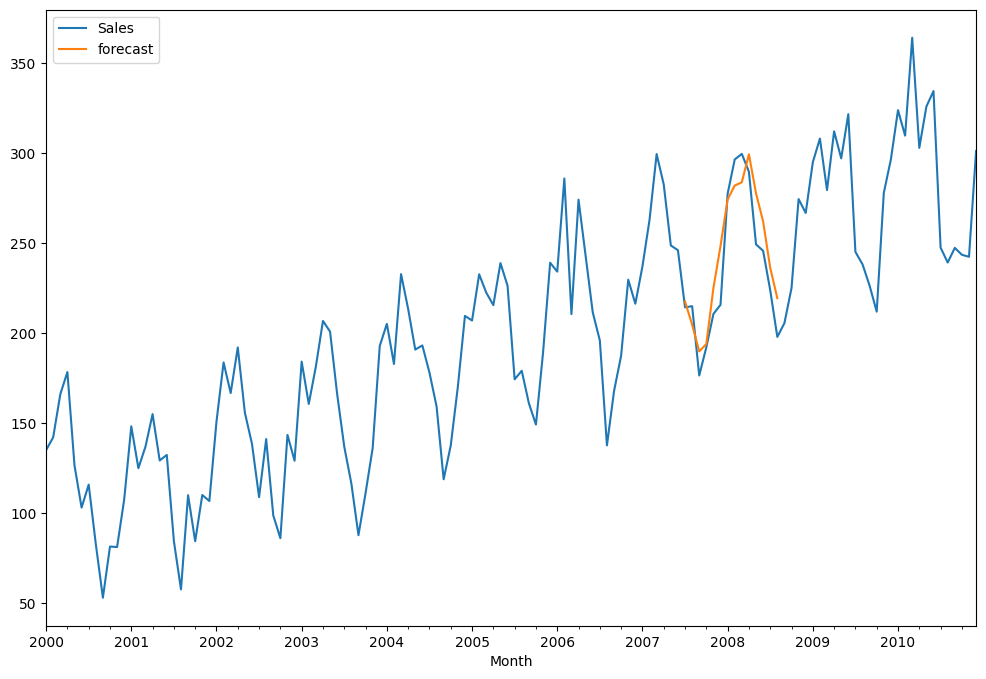

In [49]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [50]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [51]:
future_datest_df.tail()

,Sales,Sales Difference,Seasonal Difference,forecast
2012-07-01,NaN,NaN,NaN,NaN
2012-08-01,NaN,NaN,NaN,NaN
2012-09-01,NaN,NaN,NaN,NaN
2012-10-01,NaN,NaN,NaN,NaN
2012-11-01,NaN,NaN,NaN,NaN


In [52]:
future_df=pd.concat([df,future_datest_df])

/tmp/ipykernel_6127/1723908026.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_datest_df])


<Axes: >

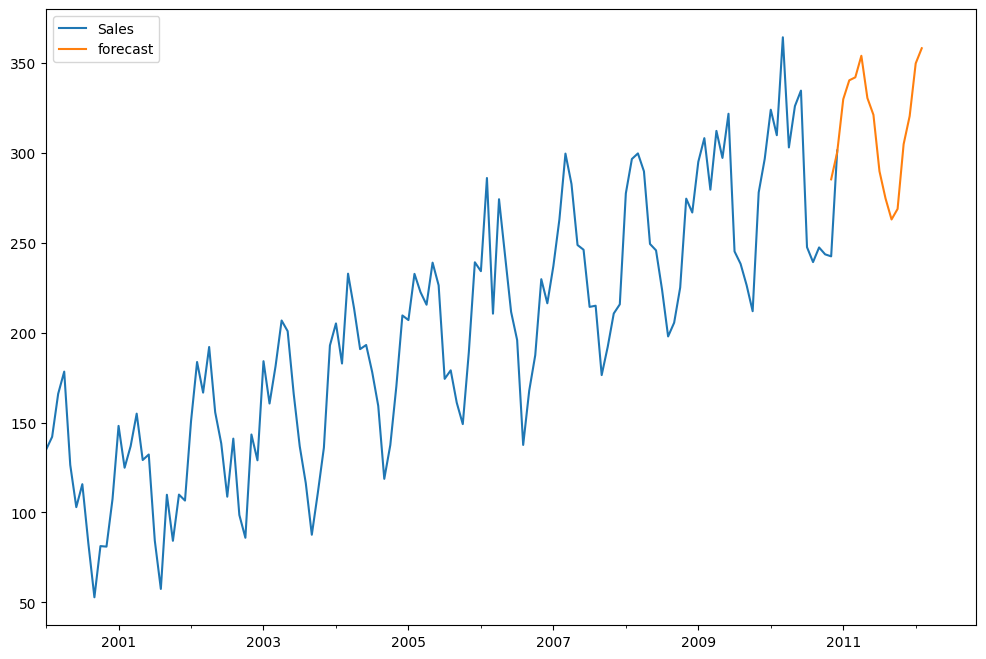

In [54]:

future_df['forecast'] = results.predict(start = 130, end = 145, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))